In [68]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import faiss                   # make faiss available
import umap
import seaborn as sns
%matplotlib inline
from byol_pytorch import BYOL

import os
import sys
import matplotlib.pyplot as plt
from sklearn import svm
sys.path.append('..')

import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from pl_bolts.models.self_supervised import SimCLR

from src.beam import UniversalDataset, Experiment, Algorithm, beam_arguments, PackedFolds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
torchvision.datasets.STL10()

In [3]:
class MiniImageNet(UniversalDataset):

    def __init__(self, hparams):

        path = hparams.path_to_data
        seed = hparams.split_dataset_seed

        super().__init__()
        
        file = os.path.join(path, 'mini_imagenet.pt')
        if not os.path.exists(file):
                        
            dataset_train = [pd.read_pickle(os.path.join(path, f'train_data_batch_{i}')) for i in range(1, 11)]


            data_train = torch.cat([torch.ByteTensor(di['data']) for di in dataset_train]).reshape(-1, 3, 64, 64)

            data_train_f = data_train.float()

            mu = data_train_f.mean(dim=(0, 2, 3), keepdim=True)
            std = data_train_f.std(dim=(0, 2, 3), keepdim=True)

            data_test = torch.ByteTensor(dataset_test['data']).reshape(-1, 3, 64, 64)

            labels_train = torch.cat([torch.LongTensor(di['labels']) for di in dataset_train])
            labels_test = torch.LongTensor(dataset_test['labels'])

            state = {'data_train': data_train, 'data_test': data_test, 
                            'labels_train': labels_train, 
                            'labels_test': labels_test, 'mu': mu,
                            'std': std}
            
            torch.save(state, file)
        else:
            state = torch.load(file)
        
        self.normalize = True
        self.data = PackedFolds({'train': state['data_train'], 'test': state['data_test']})
        self.labels = PackedFolds({'train': state['labels_train'], 'test': state['labels_test']})
        self.mu = state['mu']
        self.std = state['std']
        self.split(validation=.2, test=self.labels['test'].index, seed=seed)
        self.transform = torchvision.transforms.Resize((224, 224))

    def getitem(self, index):
        
        x = self.data[index]
        
        if self.normalize:
#             mu = self.mu
#             std = self.std
            
#             if len(x.shape) == 3:
#                 mu = mu.squeeze(0)
#                 std = std.squeeze(0)
                
#             x = (x.float() - mu) / std
            x = x.float() / 255

            
        x = self.transform(x)
            
        return {'x': x, 'y': self.labels[index]}

In [37]:
class BeamCLR(Algorithm):

    def __init__(self, hparams):

        # choose your network
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)
        encoder = simclr.encoder
        
        super().__init__(hparams, networks=encoder)

    
    def preprocess_inference(self, results=None, **kwargs):
        self.dataset.normalize = True
        return results
    
    def inference(self, sample=None, results=None, subset=None, predicting=True, **kwargs):

        if predicting:
            x = sample
        else:
            x, y = sample['x'], sample['y']

        net = self.networks['net']
        z = net(x)[0]

        if not predicting:
            return {'z': z, 'y': y}, results

        return z, results

In [26]:
path_to_data = '/home/shared/data/dataset/imagenet'
root_dir = '/home/shared/data/results'

hparams = beam_arguments(
    f"--project-name=similarity --root-dir={root_dir} --algorithm=ImageNet --identifier=dev  --device=0",
    "--epoch-length-train=50 --epoch-length-eval=20 --no-scale-epoch-by-batch-size --batch-size=128 --no-override",
    path_to_data=path_to_data)

In [5]:
%%time

dataset = MiniImageNet(hparams)

CPU times: user 15.6 s, sys: 45.1 s, total: 1min
Wall time: 13.9 s


In [27]:
experiment = Experiment(hparams, print_hyperparameters=False)

2022-07-25 11:59:57 | INFO | Creating new experiment
2022-07-25 11:59:57 | INFO | Experiment directory is: /home/shared/data/results/similarity/ImageNet/dev/0015_20220725_115957


In [38]:
alg = experiment.algorithm_generator(BeamCLR, dataset)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  rank_zero_warn(


In [39]:
features = alg.evaluate('test')

test:   2%|2         | 8/391 [00:00<?, ?it/s]

In [40]:
z = features.values['z'].detach().cpu().numpy()
y = features.values['y'].detach().cpu().numpy()

## Faiss

In [60]:
d = z.shape[-1]

res = faiss.StandardGpuResources()

# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

gpu_index_flat.add(z)         # add vectors to the index
print(gpu_index_flat.ntotal)

i = 6767

y = features.data['y']

D, I = gpu_index_flat.search(z[[i]], 100) # sanity check

print(len(np.unique(y[I[0]])))

zvi = z[I[0]]

reducer = umap.UMAP()

embedding = reducer.fit_transform(zvi)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y[I[0]])

In [62]:
D

array([[0.       , 6.1720705, 6.7868056, 6.94296  , 6.94549  , 6.9927034,
        7.199564 , 7.218704 , 7.3393707, 7.3709507, 7.4093924, 7.4566803,
        7.466445 , 7.498243 , 7.5215797, 7.5547876, 7.603799 , 7.645793 ,
        7.672599 , 7.674835 , 7.6938934, 7.7072816, 7.7255993, 7.770645 ,
        7.7741566, 7.7894583, 7.8125772, 7.8232746, 7.831172 , 7.8412504,
        7.854375 , 7.856941 , 7.8647714, 7.867754 , 7.8748703, 7.892625 ,
        7.902323 , 7.922691 , 7.9271374, 7.9293365, 7.9317265, 7.9381294,
        7.9465046, 7.9482126, 7.9633703, 7.96833  , 7.9691143, 7.994747 ,
        7.9987717, 8.016235 , 8.050839 , 8.069199 , 8.093536 , 8.096331 ,
        8.100504 , 8.105967 , 8.123019 , 8.150873 , 8.15144  , 8.160635 ,
        8.161406 , 8.172661 , 8.175581 , 8.192312 , 8.19375  , 8.205517 ,
        8.215382 , 8.221013 , 8.222821 , 8.229109 , 8.230244 , 8.231952 ,
        8.246959 , 8.254755 , 8.255495 , 8.2585945, 8.261747 , 8.262355 ,
        8.273473 , 8.280136 , 8.291529

In [64]:
I

array([[ 6767, 11748, 21910,  1387,  4648, 26590, 12614, 46937,  1447,
        19038, 30349,  7277, 36791, 25563, 33127, 23974, 16449, 47369,
        44106, 20820, 45442, 29964, 38729, 35407,  2528, 31739, 19506,
        48406, 24317, 22705, 45308, 30633, 34486,   439, 25233, 10282,
        30781, 47989, 36117, 17605, 24693,  9938, 30521, 11840,  3285,
        32881, 36555,  5678, 17878,  5824, 29382, 13031,  9811, 34767,
         2514, 35601, 47193, 44800, 26998,  1591,  5765, 34258, 47805,
        32886,  5704, 16003, 26976,  2804, 41173, 45705, 28643,  1506,
         6859, 31587, 28893,  2157, 39735, 34199, 30445, 15496, 35517,
        46435, 44871, 26754, 18206, 20932,  5807,  5976, 17364, 44407,
        32486, 41193, 36663, 26124, 29129, 24668, 25603, 44662, 33910,
        13921]])

In [63]:
y[i]

tensor(287)

In [49]:
def show_image(i):
    
    dataset.normalize = False
    im = np.array(dataset[i][1]['x'].permute(1, 2, 0))
    plt.imshow(im)
    dataset.normalize = True
    

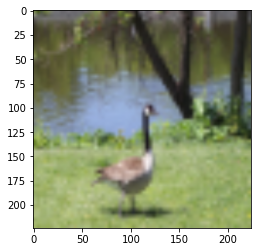

In [67]:
show_image(1387)

In [90]:
import lightgbm as lgb

train_data = lgb.Dataset(np.array(z), label=np.array(y)-1)

validation_data = train_data.create_valid('validation.svm')

num_round = 10
param = {'num_leaves': 31, 'objective': 'multiclass', 'num_class': 1000}
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

In [70]:
classifier = LogisticRegression(n_jobs=-1, max_iter=10)
classifier.fit(z, y)

y_hat = classifier.predict(z)
float(accuracy_score(y, y_pred=y_hat))

KeyboardInterrupt: 